In [15]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import util
import SSA
import importlib
import tensorflow as tf
from models import shallow_vgg
from skimage.transform import resize
from tensorflow.keras import losses, metrics, optimizers, callbacks

importlib.reload(shallow_vgg)

plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] ='Malgun Gothic'

In [11]:
model = shallow_vgg.CompositeVGG()
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stft_input (InputLayer)        [(None, 128, 32, 24  0           []                               
                                )]                                                                
                                                                                                  
 recur_input (InputLayer)       [(None, 1024, 1024,  0           []                               
                                 4)]                                                              
                                                                                                  
 conv2d_78 (Conv2D)             (None, 128, 32, 64)  13888       ['stft_input[0][0]']             
                                                                                           

In [2]:
def mean_error(y_true, y_pred):
    def _mean_error_score(y_true, y_pred):
        return np.mean(y_true - y_pred)
    score = tf.py_function(func=_mean_error_score, inp=[y_true, y_pred], Tout=tf.float32, name='mean_error')
    return score

In [3]:
data_path = "./data/2022_04_01_motion_imu/"
fn_list = os.listdir(data_path)
# user_list = ["인", "데이비드", "제이슨", "로제", "마이어", "찰스", "지나", "제임스", "미쉘"]
user_list = ["인", "데이비드", "제이슨", "로제", "마이어", "찰스", "제임스", "미쉘"]

leg_score = {"인": 31.46, "데이비드": 36.62, "제이슨": 17.51, "로제": 22.75, "마이어": 38.76, "찰스": 41.19, "지나": 20.04, "제임스": 31.66, "미쉘": 13.35}

body_info = {"인": [171, 70], "데이비드": [173, 67], "제이슨": [172, 47], "로제": [158, 53], "마이어": [174, 53], "찰스": [174, 64], "지나": [], "제임스": [171, 62], "미쉘": [159, 52]}


dic_list = {}

for fn in fn_list:
    user_name = fn.split("_")[0]
    if user_name not in user_list:
        continue

    if user_name not in dic_list:
        dic_list[user_name] = {}
        dic_list[user_name]["y"] = leg_score[user_name]
        dic_list[user_name]["body_info"] = body_info[user_name]

    df = pd.read_csv(f"{data_path}{fn}", sep=",", names=["ax", "ay", "az", "gx", "gy", "gz"])
    np_data = df.to_numpy()
    cpy_data = np_data.copy()

    ssa_list = []
    stft_list = []
    for i in range(6):
        ssa = SSA.SSA(np_data[:, i], L=20)
        ssa_list.append(ssa.reconstruct([0]).to_numpy())
        # target_data = np_data[:, i]
        target_data = ssa.reconstruct([0])
        cpy_data[:, i] = ssa.reconstruct([0])
        stft = resize(util.stft(target_data, 64), (32, 128), mode='constant')
        stft_list.append(stft)
    np_ssa_list = np.array(ssa_list)
    np_stft_list = np.array(stft_list)
    print(np_stft_list.shape)

    if "stft" in dic_list[user_name]:
        dic_list[user_name]["stft"].append(np_stft_list)
    else:
        dic_list[user_name]["stft"] = [np_stft_list]

    recur_plot = util.recurrence_plot(cpy_data, 10000)  # 뒤의 clipping은 안 씀
    recur_plot = np.expand_dims(resize(recur_plot, (1024, 1024), mode='constant'), axis=0)
    if "recur_plot" in dic_list[user_name]:
        dic_list[user_name]["recur_plot"].append(recur_plot)
    else:
        dic_list[user_name]["recur_plot"] = [recur_plot]



(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)
(6, 32, 128)


In [4]:
for user_name in dic_list:
    concat_arr = np.concatenate(dic_list[user_name]["stft"])
    dic_list[user_name]["image"] = concat_arr.transpose((2, 1, 0))  # (time, freq, chan=부착위치)
    recur_concat_arr = np.concatenate(dic_list[user_name]["recur_plot"]) / 10000
    dic_list[user_name]["recur_image"] = recur_concat_arr.transpose((2, 1, 0))

start


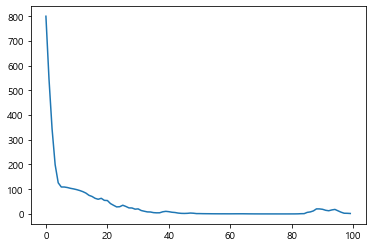

1/1 [==============================] - 0s 267ms/step - loss: 139.7568 - mean_squared_error: 139.7568 - mean_absolute_error: 11.8219 - mean_error: -11.8219


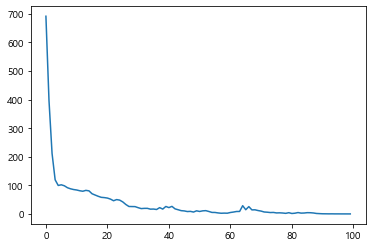

1/1 [==============================] - 0s 230ms/step - loss: 291.6192 - mean_squared_error: 291.6192 - mean_absolute_error: 17.0769 - mean_error: 17.0769


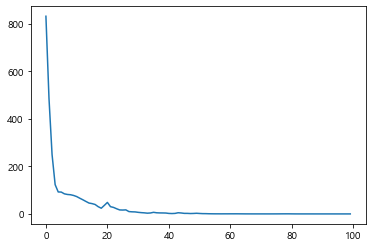

1/1 [==============================] - 0s 232ms/step - loss: 5.8653 - mean_squared_error: 5.8653 - mean_absolute_error: 2.4218 - mean_error: -2.4218


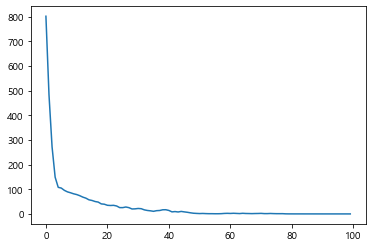

1/1 [==============================] - 0s 234ms/step - loss: 210.4306 - mean_squared_error: 210.4306 - mean_absolute_error: 14.5062 - mean_error: -14.5062


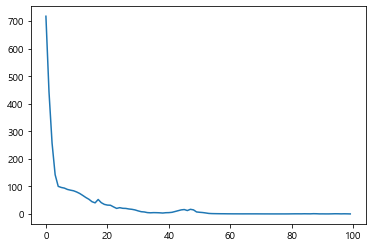

1/1 [==============================] - 0s 234ms/step - loss: 135.7845 - mean_squared_error: 135.7845 - mean_absolute_error: 11.6527 - mean_error: 11.6527


KeyboardInterrupt: 

In [5]:
print("start")
loss_history = []
for i in range(len(user_list)):
    test_X = [np.expand_dims(dic_list[user_list[i]]["image"], axis=0), np.expand_dims(dic_list[user_list[i]]["recur_image"], axis=0)]
    test_y = np.array([dic_list[user_list[i]]["y"]])

    train_X = []
    train_y = []
    recur_X = []
    image_X = []
    body_X = []
    for j in range(len(user_list)):
        if i == j:
            continue
        recur_X.append(dic_list[user_list[j]]["recur_image"])  # normalization 필요
        image_X.append(dic_list[user_list[j]]["image"])  # normalization 필요
        train_y.append(dic_list[user_list[j]]["y"])
        body_X.append(dic_list[user_list[j]]["body_info"])

    train_dataset = tf.data.Dataset.from_tensor_slices(((np.array(image_X), np.array(recur_X)), np.array(train_y))).batch(1)

    model = shallow_vgg.CompositeVGG()
    loss = losses.MeanSquaredError()
    optimizer = optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss={'final_output': loss}, metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), mean_error])
    history = model.fit(train_dataset,
                        epochs=100, verbose=0)
    plt.plot(history.history["loss"])
    plt.show()
    eval_metric = model.evaluate(test_X, test_y)
    loss_history.append(eval_metric[3])

In [ ]:
print(loss_history)
print("mean", np.mean(loss_history))
print("std", np.std(loss_history))

In [23]:
user_list = ["인", "데이비드", "제이슨", "마이어", "찰스", "제임스"]

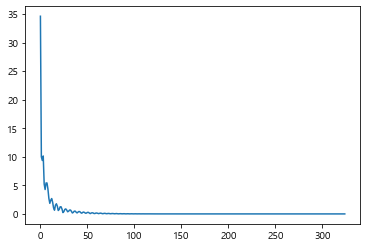

training error: 0.06041279117371617
1/1 [==============================] - 0s 146ms/step - loss: 6.0584 - mean_squared_error: 6.0584 - mean_absolute_error: 2.4614 - mean_error: 2.4614


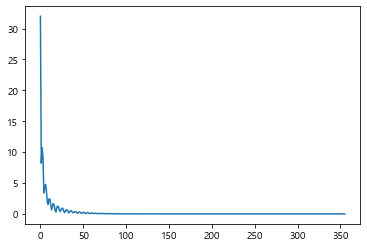

training error: 0.053184786053937026
1/1 [==============================] - 0s 143ms/step - loss: 12.6990 - mean_squared_error: 12.6990 - mean_absolute_error: 3.5636 - mean_error: -3.5636


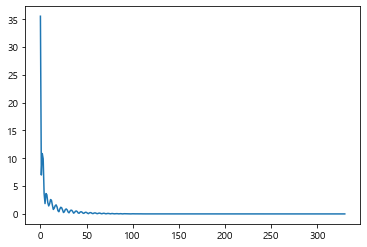

training error: 0.06870685028592595
1/1 [==============================] - 0s 147ms/step - loss: 301.1936 - mean_squared_error: 301.1936 - mean_absolute_error: 17.3549 - mean_error: -17.3549


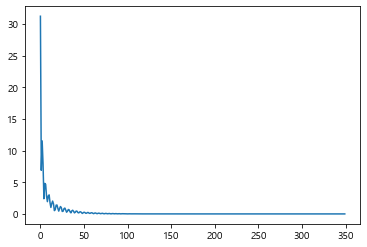

training error: 0.04786499204759894
1/1 [==============================] - 0s 144ms/step - loss: 39.9223 - mean_squared_error: 39.9223 - mean_absolute_error: 6.3184 - mean_error: 6.3184


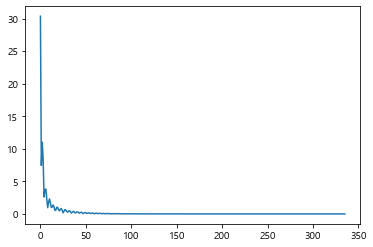

training error: 0.050496487386613866
1/1 [==============================] - 0s 147ms/step - loss: 87.9707 - mean_squared_error: 87.9707 - mean_absolute_error: 9.3793 - mean_error: 9.3793


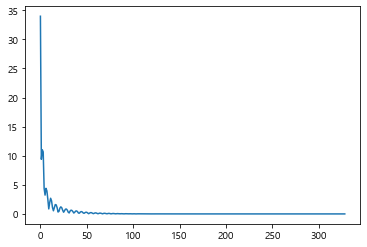

training error: 0.059398290989840646
1/1 [==============================] - 0s 148ms/step - loss: 26.3596 - mean_squared_error: 26.3596 - mean_absolute_error: 5.1342 - mean_error: 5.1342


In [24]:
loss_history = []
for i in range(len(user_list)):
    test_X = np.expand_dims(dic_list[user_list[i]]["image"], axis=0)
    test_y = np.array([dic_list[user_list[i]]["y"]])
    train_X = []
    train_y = []
    for j in range(len(user_list)):
        if i == j:
            continue
        train_X.append(dic_list[user_list[j]]["image"])
        train_y.append(dic_list[user_list[j]]["y"])
    train_X = np.array(train_X)
    train_y = np.array(train_y)
    model = shallow_vgg.ShallowVGG(1, 1, 1)
    loss = losses.MeanSquaredError()
    optimizer = optimizers.Adam(learning_rate=1e-3)
    es = callbacks.EarlyStopping(
        monitor='mean_absolute_error',
        min_delta=0,
        patience=50,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
    model.compile(optimizer=optimizer, loss=loss, metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), mean_error])
    history = model.fit(train_X, train_y, epochs=500, verbose=0, callbacks=[es])
    plt.plot(history.history["mean_absolute_error"])
    plt.show()
    print("training error:", np.mean(history.history["mean_error"]))
    eval_metric = model.evaluate(test_X, test_y)
    loss_history.append(eval_metric[3])

In [25]:
print(loss_history)
print("mean", np.mean(loss_history))
print("std", np.std(loss_history))

[2.4613819122314453, -3.5635604858398438, -17.354928970336914, 6.318412780761719, 9.3792724609375, 5.134160995483398]
mean 0.39578978220621747
std 8.881288641496818


In [6]:
for key in dic_list:
    print(dic_list[key]["y"])

36.62
22.75
38.76
13.35
31.46
17.51
31.66
41.19
